## to do

random forest

https://github.com/dgriffiths3/ml_segmentation



# Satellite image recogniton 

## FCM model (133M parameters) 

## Read dataset

In [1]:
import numpy as np
import os
from tensorflow.keras import layers
import keras
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
from PIL import ImageOps
from PIL import Image 
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from keras.callbacks import EarlyStopping


### read variables in mmap mode to save memory 

In [2]:
input_dat = np.load(os.path.join('../data_fin/train_input_dat.npy'), mmap_mode='r')
target_dat = np.load(os.path.join('../data_fin/train_target_dat.npy'), mmap_mode='r')

In [3]:
train_input_dat=input_dat[1500:,:,:,:]
train_target_dat=target_dat[1500:,:,:,:]

val_input_dat=input_dat[:1500,:,:,:]
val_target_dat=target_dat[:1500,:,:,:]



## What classes are in the dataset

### Entire dataset

In [ ]:
flat=np.argmax(target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Traing dataset

In [ ]:
flat=np.argmax(train_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Testing dataset

In [ ]:
flat=np.argmax(val_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

## Sample image and mask

(224, 224, 3)


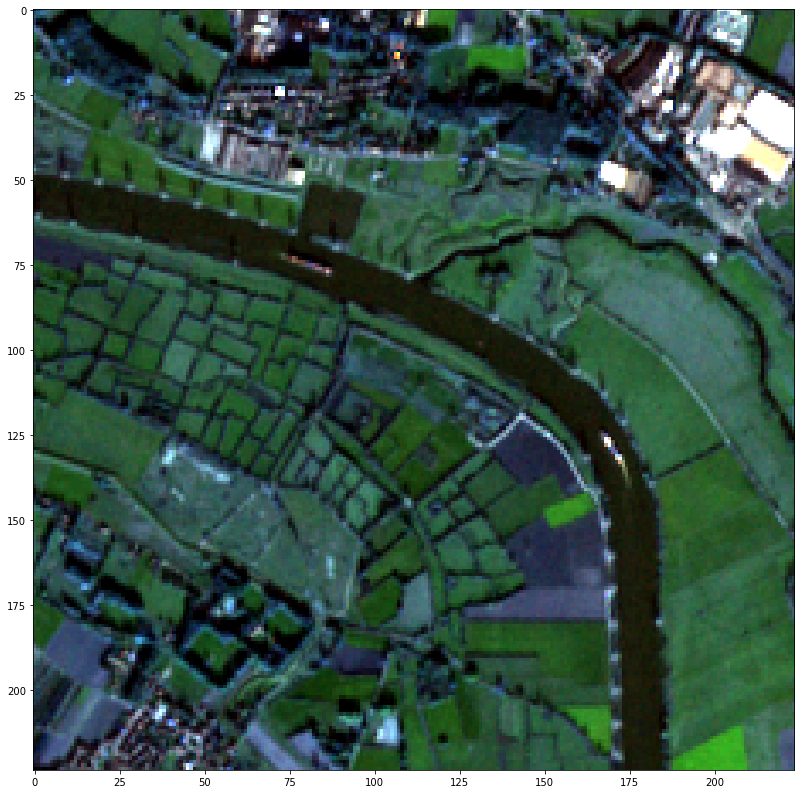

/home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


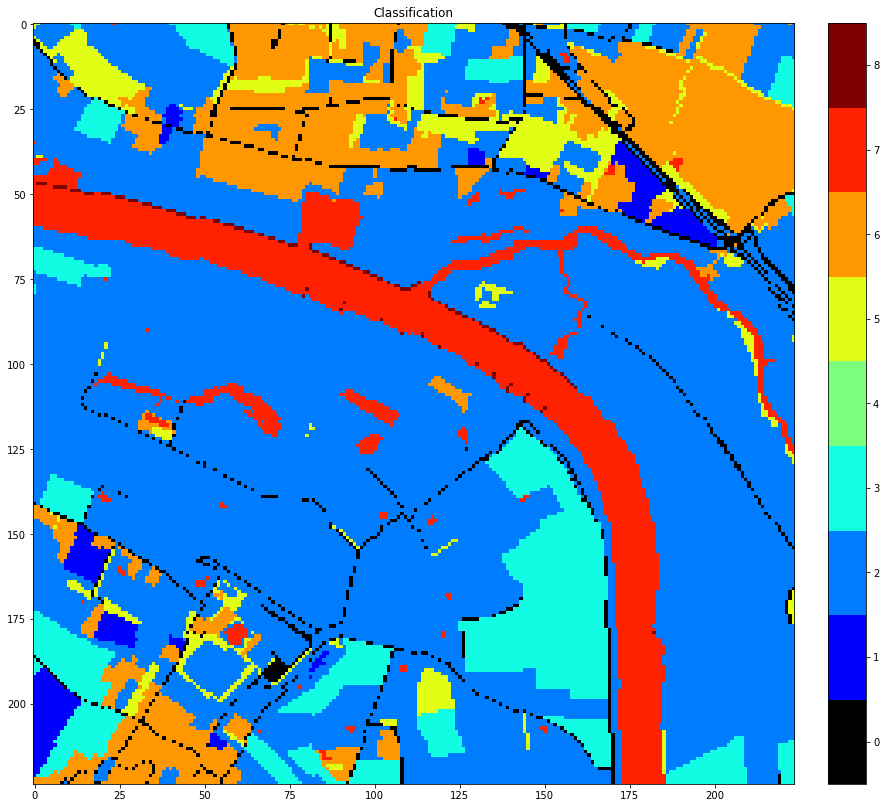

In [4]:

def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(15, 14)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(15, 14)
    plt.show()
    
    
    
    
# Display results for validation image #10
i = 78


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
    

## VGGSegnet model (13M parameters) 

In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


import os


IMAGE_ORDERING = 'channels_last'


def FCN32( n_classes ,  input_height=224, input_width=224 , vgg_level=3):

    assert input_height%32 == 0
    assert input_width%32 == 0

    # https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5
    img_input = Input(shape=(input_height,input_width,3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
    f5 = x

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense( 1000 , activation='softmax', name='predictions')(x)

    vgg  = Model(  img_input , x  )
    #vgg.load_weights(VGG_Weights_path)

    o = f5

    o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)
    o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    o = ( Conv2D( n_classes ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    o = Conv2DTranspose( n_classes , kernel_size=(32,32) ,  strides=(32,32) , use_bias=False ,  data_format=IMAGE_ORDERING )(o)
    #o_shape = Model(img_input , o ).output_shape

    #outputHeight = o_shape[2]
    #outputWidth = o_shape[3]

    #print ("koko" , o_shape)

    #o = (Reshape(( -1  , outputHeight*outputWidth   )))(o)
    #o = (Permute((2, 1)))(o)
    o = (Activation('softmax'))(o)
    model = Model( img_input , o )
    #model.outputWidth = outputWidth
    #model.outputHeight = outputHeight

    return model


In [6]:
model = FCN32( 9 ,  input_height=224, input_width=224 , vgg_level=3)

In [7]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Train

In [11]:
#Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
  
#  
from keras.callbacks import EarlyStopping

model_name='FCN-133Mv004.h5'

batch_size = 16
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics='acc'
)


early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    #min_delta=0,
    patience=20,
    #verbose=1,
    #mode='auto',
    #baseline=None,
    restore_best_weights=True
)



In [12]:
# Train the model, doing validation at the end of each epoch.
epochs = 200
history=model.fit(train_input_dat, train_target_dat, epochs=epochs, batch_size=batch_size,
                  validation_data=(val_input_dat,val_target_dat), callbacks=[early_stopping_monitor])

Epoch 1/200
229/229 [==============================] - 105s 457ms/step - loss: 1.9166 - acc: 0.3482 - val_loss: 1.8016 - val_acc: 0.3552
Epoch 2/200
229/229 [==============================] - 102s 447ms/step - loss: 1.8575 - acc: 0.3456 - val_loss: 1.8164 - val_acc: 0.3552
Epoch 3/200
229/229 [==============================] - 104s 455ms/step - loss: 1.8913 - acc: 0.3481 - val_loss: 1.8837 - val_acc: 0.2355
Epoch 4/200
229/229 [==============================] - 106s 463ms/step - loss: 1.8819 - acc: 0.3496 - val_loss: 1.7050 - val_acc: 0.4111
Epoch 5/200
229/229 [==============================] - 104s 453ms/step - loss: 1.8386 - acc: 0.3519 - val_loss: 1.7047 - val_acc: 0.4030
Epoch 6/200
229/229 [==============================] - 107s 465ms/step - loss: 1.8878 - acc: 0.3506 - val_loss: 1.8017 - val_acc: 0.3549
Epoch 7/200
229/229 [==============================] - 103s 452ms/step - loss: 1.8204 - acc: 0.3568 - val_loss: 1.8659 - val_acc: 0.3552
Epoch 8/200
229/229 [====================

229/229 [==============================] - 105s 459ms/step - loss: 0.8440 - acc: 0.7001 - val_loss: 1.0457 - val_acc: 0.6505
Epoch 59/200
229/229 [==============================] - 105s 460ms/step - loss: 0.8415 - acc: 0.7017 - val_loss: 1.0774 - val_acc: 0.6514
Epoch 60/200
229/229 [==============================] - 105s 457ms/step - loss: 0.8395 - acc: 0.7021 - val_loss: 1.0332 - val_acc: 0.6544
Epoch 61/200
229/229 [==============================] - 105s 457ms/step - loss: 0.8386 - acc: 0.7030 - val_loss: 1.0555 - val_acc: 0.6503
Epoch 62/200
229/229 [==============================] - 102s 445ms/step - loss: 0.8346 - acc: 0.7035 - val_loss: 1.0679 - val_acc: 0.6503
Epoch 63/200
229/229 [==============================] - 101s 442ms/step - loss: 0.8332 - acc: 0.7044 - val_loss: 1.0588 - val_acc: 0.6520
Epoch 64/200
229/229 [==============================] - 101s 442ms/step - loss: 0.8257 - acc: 0.7063 - val_loss: 1.0642 - val_acc: 0.6513
Epoch 65/200
229/229 [=========================

In [15]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'models/history-'+model_name+'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [16]:
model.save('models/'+hist_df['val_acc'].iloc[[-1]].to_string()+'-' +model_name)

## Evaluate model

## Visualizing model performance
### Let's plot the model accuracy and loss for the training and the validating set. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

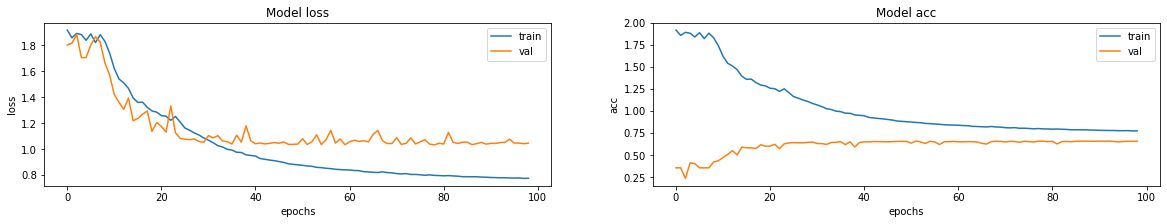

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'acc']):
    ax[i].plot(hist_df['loss'])
    ax[i].plot(hist_df["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Confution matrix

https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

In [18]:
batch_size=8
Y_pred = model.predict_generator((val_input_dat,val_target_dat), 1500 // batch_size+1)
y_pred= np.argmax(Y_pred, axis=3).flatten()
y= np.argmax(val_target_dat, axis=3).flatten()


Instructions for updating:
Please use Model.predict, which supports generators.


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['0','1','2','3','4','5','6','7','8']

cm = confusion_matrix(y, y_pred)


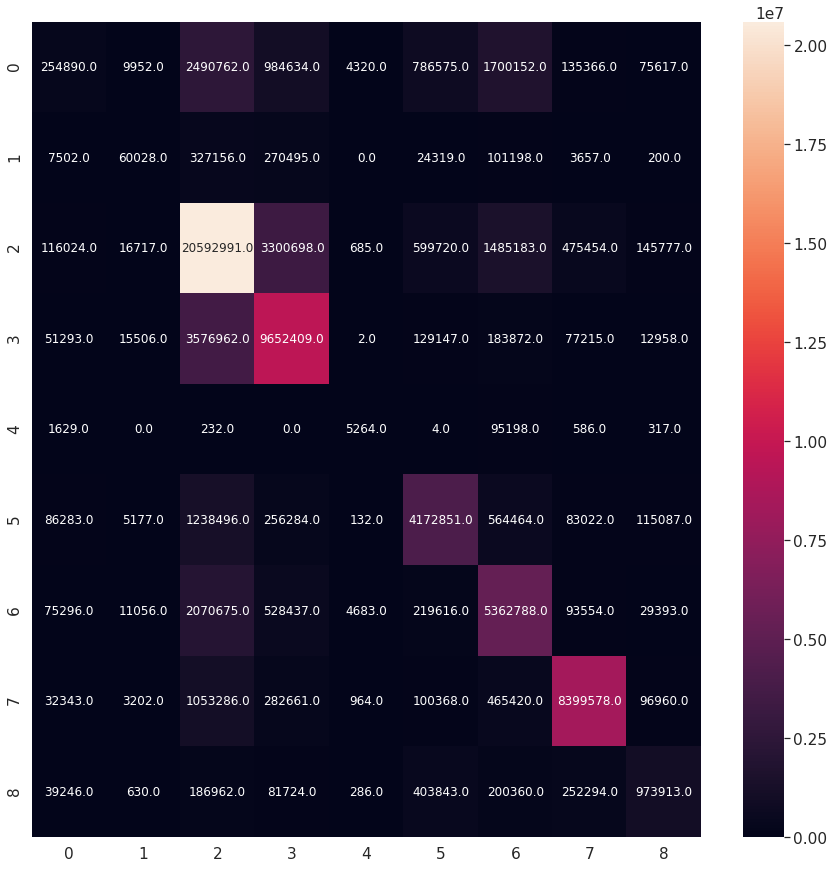

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(9), range(9))
plt.figure(figsize=(15,15))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='.1f', annot_kws={"size": 12}) # font size

plt.show()

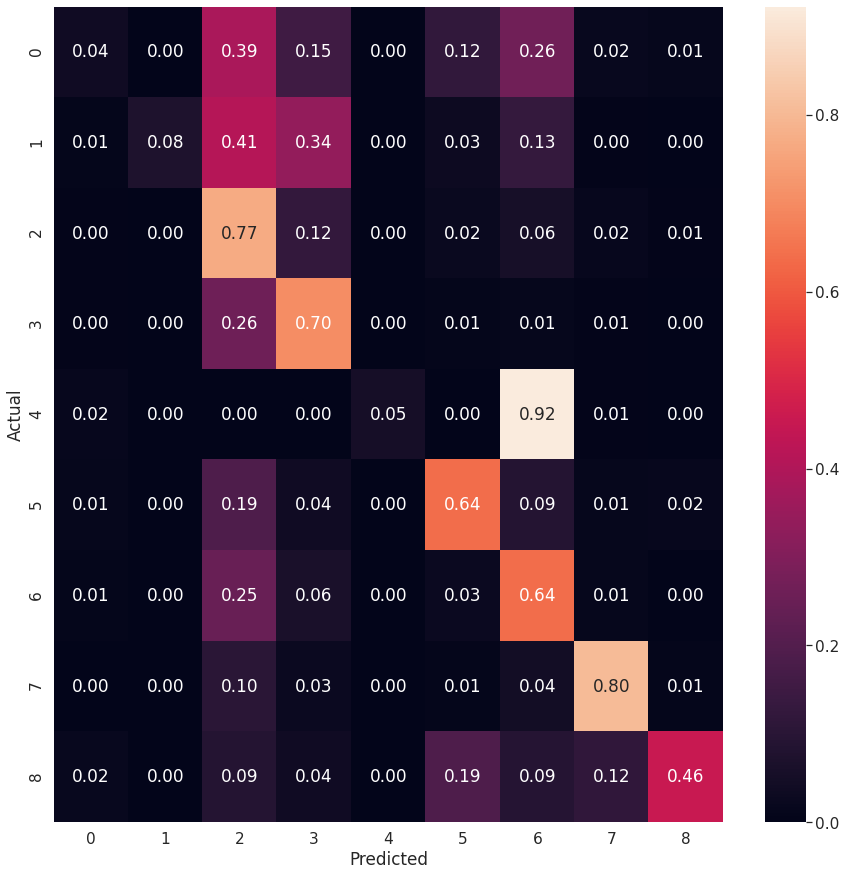

In [21]:
# Normalise
cmn = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Diagonal sum of confusion matrix

In [22]:
sum=0
for i in range(0,cm.shape[0]):
    sum=sum+cm[i][i]
"{0:,.2f}".format(sum)

'49,474,712.00'

## Model Evaluate

## Visualize predictions

In [ ]:
Y_pred.shape

In [ ]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(10, 10)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    
# Display results for validation image #10
i = 15


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
# Display mask predicted by our model
#display_mask(i)  # Note that the model only sees inputs at 150x150.
display_target(Y_pred[i])


https://www.kaggle.com/meaninglesslives/unet-resnet34-in-keras